In [88]:
import os
from OCC.Display.SimpleGui import init_display
from OCC.Extend.DataExchange import read_iges_file

def read_file(path, is_display=False):
    
    if os.path.exists(path):           # 防止路徑不存在
        shapes = read_iges_file(path)  # 一定要用這個方法讀取
    else:
        print("檔案路徑錯誤！")
    
    if is_display:
        # 初始化 3D 顯示環境
        display, start_display, add_menu, add_function_to_menu = init_display()
        display.DisplayShape(shapes, update=True)
        start_display()
        
    return shapes

In [100]:
# path = r"C:\alan\ITRI\ITRI-test\model\complex_3.IGS"#物件路徑
path = r"C:\alan\ITRI\ITRI-test\model\HCG_faucet_LF3188.IGS"
object_1 = read_file(path, is_display=True)
object_1=object_1[0]

In [90]:
import os
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopoDS import topods
from OCC.Core.TopAbs import TopAbs_FACE
from OCC.Display.OCCViewer import OffscreenRenderer

# 平面影像儲存路徑
# image_directory = r"C:\NTHU\IRTI-Project\Images"

def plane_segmentation(object, is_save=True):
    
    explorer = TopExp_Explorer(object, TopAbs_FACE) # TopAbs_FACE 只對面感興趣
    faces = []
    index = 1
    # # 宣告一個渲彩器(不會顯示出來)
    # renderer = OffscreenRenderer()
    # renderer.Create()
    
    while explorer.More():
        
        face = topods.Face(explorer.Current())
        faces.append(face)                     # 將當前的面儲存到 list 中

        index += 1
        explorer.Next()                      # 移動到下一個面
    
    return faces

In [91]:
object_1_faces = plane_segmentation(object_1)
print("object_1 總共有", len(object_1_faces), "個物件")

object_1 總共有 100 個物件


In [ ]:
from OCC.Core.BRepGProp import brepgprop_SurfaceProperties
from OCC.Core.GProp import GProp_GProps
from OCC.Core.TopoDS import TopoDS_Shape

def calculate_surface_area(shape):
    # 將 shape 轉換為 TopoDS_Shape
    topods_shape = TopoDS_Shape(shape)

    # 初始化表面屬性
    surface_props = GProp_GProps()

    # 計算表面屬性
    brepgprop_SurfaceProperties(topods_shape, surface_props)
    

    # 獲取表面積
    surface_area = surface_props.Mass()

    return surface_area

In [92]:
import os
import numpy as np
from OCC.Core.IGESControl import IGESControl_Reader
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopoDS import topods_Face, TopoDS_Face, TopoDS_Shape
from OCC.Core.BRepAdaptor import BRepAdaptor_Surface
from OCC.Core.BRepLProp import BRepLProp_SLProps
from OCC.Core.TopoDS import topods_Edge
from OCC.Core.TopAbs import TopAbs_FACE
from OCC.Core.TopAbs import TopAbs_EDGE
from OCC.Core.gp import gp_Pnt, gp_Vec
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeEdge, BRepBuilderAPI_MakeVertex
from OCC.Core.Bnd import Bnd_Box
from OCC.Core.BRepBndLib import brepbndlib_Add
from OCC.Core.gp import gp_Pnt
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape
from OCC.Display.OCCViewer import rgb_color
from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Lin
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Section
from OCC.Core.TopAbs import TopAbs_VERTEX
from OCC.Core.BRep import BRep_Tool
import csv
def sample_feature_points(face,data): 
    
    face = topods.Face(face)
    adaptor_surface = BRepAdaptor_Surface(face, True)
    props = BRepLProp_SLProps(adaptor_surface, 2, 0.01)
    u_min, u_max, v_min, v_max = adaptor_surface.FirstUParameter(), adaptor_surface.LastUParameter(), adaptor_surface.FirstVParameter(), adaptor_surface.LastVParameter()

    u_values = np.linspace(u_min, u_max, num=5)
    v_values = np.linspace(v_min, v_max, num=5)
    X=[]
    Y=[]
    Z=[]
    Nx=[]
    Ny=[]
    Nz=[]
    Min_curvature=[]
    Max_curvature=[]
    for u in u_values:
        for v in v_values:
            position=adaptor_surface.Value(u, v)
            x=position.X()#點座標
            X.append(x)
            y=position.Y()
            Y.append(y)
            z=position.Z()
            Z.append(z)
            u_mid = (u_min + u_max) / 2
            v_mid = (v_min + v_max) / 2
            props.SetParameters(u, v)

            if props.IsCurvatureDefined():
                normal = props.Normal()#點法向量
                if face.Orientation() == TopAbs_FACE:
                    normal.Reverse()
                nx=normal.X()
            
                ny=normal.Y()
                nz=normal.Z()
                min_curvature = props.MinCurvature()
                max_curvature = props.MaxCurvature()
            else:
                nx=0
                ny=0
                nz=0
                min_curvature = 0
                max_curvature = 0 
            Nx.append(nx)
            Ny.append(ny)
            Nz.append(nz)
            Min_curvature.append(min_curvature)
            Max_curvature.append(max_curvature)     

    average_X= sum(X) / len(X)
    average_Y= sum(Y) / len(Y)     
    average_Z= sum(Z) / len(Z)   
    average_Nx= sum(Nx) / len(Nx)
    average_Ny= sum(Ny) / len(Ny)
    average_Nz= sum(Nz) / len(Nz)
    average_Min_curvature= sum(Min_curvature) / len(Min_curvature)  
    average_Max_curvature= sum(Max_curvature) / len(Max_curvature)     
    h=(average_Min_curvature+average_Max_curvature)/2
    g=average_Min_curvature*average_Max_curvature  
    row = [average_X,average_Y,average_Z,average_Nx,average_Ny,average_Nz,h,g,average_Min_curvature,average_Max_curvature]
    data.append(row) 


 


In [93]:
# # 準備寫入 CSV 的數據
# data = []
# for i, vertex in enumerate(v):
#     # Combine position, normal, and principal curvatures into one list
#     # row = list(vertex) + list(normals[i]) + [h[i], g[i]]
#     row = list(vertex) + [h[i]]
#     data.append(row)

# # 寫入 CSV 文件
# with open('output.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     # # 寫入標題
#     # writer.writerow(['x', 'y', 'z', 'nx', 'ny', 'nz', 'k1', 'k2'])
#     # 寫入數據行
#     writer.writerows(data)

face_index = 0
data = []
for face in object_1_faces:
    face = topods_Face(face)
    face_index += 1
       
    sample_feature_points(face,data)

# 寫入 CSV 文件
with open('sample_feature_points.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # # 寫入標題
    # writer.writerow(['x', 'y', 'z', 'nx', 'ny', 'nz', 'k1', 'k2'])
    # 寫入數據行
    writer.writerows(data)     
    

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_29652\2340228560.py:20: DeprecationWarning:

Call to deprecated function topods_Face since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method topods.Face

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_29652\2340228560.py:20: DeprecationWarning:

Call to deprecated function topods_Face since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method topods.Face

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_29652\2340228560.py:20: DeprecationWarning:

Call to deprecated function topods_Face since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the static method topods.Face

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_29652\2340228560.py:20: DeprecationWarning:

Call to deprecated function topods_Face since pythonocc-core 7.7.1. This function will be removed in a future release, please rather use the

# 減法聚類法

[[ 7.81952881e+01  1.81561019e+01  7.30459853e+01 -3.08797213e-01
  -6.29795486e-01  4.73344139e-01  1.95451873e-01 -8.98200131e-07
  -2.29773918e-06  3.90906043e-01]
 [ 8.53965700e+01  8.61572723e+00  7.56051458e+01 -4.99692883e-01
  -3.49006492e-02  8.65499259e-01 -1.29736191e-23 -5.44997189e-25
  -7.38239249e-13  7.38239249e-13]
 [ 6.48634452e+01  1.89344362e+01  6.53822413e+01  3.08279038e-01
   6.30696379e-01 -4.72292871e-01 -1.95455118e-01 -3.90253764e-07
  -3.90911235e-01  9.98318106e-07]
 [ 7.63475550e+01  1.88995676e+01  7.68452616e+01 -8.47994930e-03
  -9.96330506e-01 -8.47479330e-02  1.91018255e-03 -2.15646046e-05
  -3.11111230e-03  6.93147740e-03]
 [ 9.44245294e+01  1.45227993e+01  8.22837574e+01 -5.27478598e-01
  -5.28442705e-01  3.45502418e-01  2.12452284e-01  1.33196115e-02
   3.40808694e-02  3.90823699e-01]
 [ 8.53965700e+01 -8.61572723e+00  7.56051458e+01 -4.99692883e-01
   3.49006492e-02  8.65499259e-01 -1.29087431e-23 -5.45012679e-25
  -7.38249740e-13  7.38249740e-13

C:\Users\sw_ya\AppData\Local\Temp\ipykernel_29652\2417758247.py:14: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



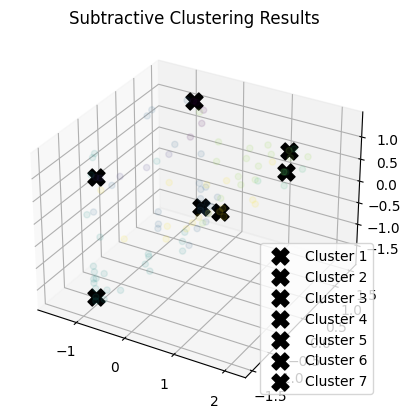

Subtractive cluster centers
c1 = [-0.79767559  1.33526994  1.11187113  0.06610037 -0.91866941 -1.21613959
  0.11004275  0.09695608  0.10239999  2.51023543]
c2 = [-0.79767559 -1.32935947  1.11187113  0.06610037  0.9164549  -1.21613959
  0.11004275  0.09695608  0.10239999  2.51023543]
c3 = [-0.7516902   1.48019963 -1.44173617  0.19049797  1.48224951  0.24104625
  0.10006756  0.09693811  0.10167426 -0.52208029]
c4 = [-0.7516902  -1.47428917 -1.44173617  0.19049797 -1.48446403  0.24104625
  0.10006756  0.09693811  0.10167426 -0.52208029]
c5 = [ 2.07563542 -0.12850135  1.31150208 -1.27866258 -0.16780646 -0.84532192
  0.10105265  0.09611039  0.10201332 -0.31027408]
c6 = [ 1.40220292  1.00626475  0.83957925  0.04609537 -1.48292186  0.02596418
  0.10085806  0.09693025  0.10234113 -0.48152096]
c7 = [ 1.40220554 -1.00035403  0.83958077  0.04609534  1.48070735  0.02596423
  0.10085806  0.09693025  0.10234113 -0.48152089]


In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import matplotlib.cm as cm

ra = 0.5
rb = ra * 1.15
Eup = 0.6
Edown = 0.15
cluster_center = []

def set_colors(labels, n_clusters):
    cmap = cm.get_cmap('viridis', n_clusters)  # 使用'viridis'颜色映射
    return [cmap(label) for label in labels]

# 读取数据并归一化
DataFrame = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points.csv", header=None)
DataMatrix = DataFrame.to_numpy()
normalized_data_matrix = skp.scale(DataMatrix, axis=0)
print(DataMatrix)

# 初始化潜力值
size = len(normalized_data_matrix)
potential = [0.0] * size

# 计算初始潜力值
for i in range(size):
    Xi = normalized_data_matrix[i]
    for j in range(i + 1, size):
        Xj = normalized_data_matrix[j]
        value = np.exp(-4.0 * ((Xi[0] - Xj[0]) ** 2 + (Xi[1] - Xj[1]) ** 2 + (Xi[2] - Xj[2]) ** 2) / (ra / 2) ** 2)
        potential[i] += value
        potential[j] += value

max_potential_value = max(potential)  # p1
max_potential_index = potential.index(max_potential_value)

# 减法聚类算法
current_max_value = max_potential_value
criteria = 1
while criteria and current_max_value:
    criteria = 0
    max_potential_vector = normalized_data_matrix[max_potential_index]  # x1
    potential_ratio = current_max_value / max_potential_value  # Pk and MaxPValue

    if potential_ratio > Eup:
        criteria = 1
    elif potential_ratio > Edown:
        dmin = np.min([(max_potential_vector[0] - cc[0]) ** 2 + (max_potential_vector[1] - cc[1]) ** 2 +
                       (max_potential_vector[2] - cc[2]) ** 2 for cc in cluster_center])
        if ((dmin / ra) + potential_ratio) >= 1:
            criteria = 1
        else:
            criteria = 2
    elif potential_ratio < Edown:
        break

    if criteria == 1:
        cluster_center.append(max_potential_vector)
        for i in range(size):
            Xj = normalized_data_matrix[i]
            potential_value = potential[i]
            potential_value = potential_value - (current_max_value * np.exp(-4.0 *
                                                ((max_potential_vector[0] - Xj[0]) ** 2 +
                                                (max_potential_vector[1] - Xj[1]) ** 2 +
                                                (max_potential_vector[2] - Xj[2]) ** 2)) / (rb / 2) ** 2)
            if potential_value < 0:
                potential_value = 0
            potential[i] = potential_value
        current_max_value = max(potential)  # p1
        max_potential_index = potential.index(current_max_value)
    elif criteria == 2:
        potential[max_potential_index] = 0
        current_max_value = max(potential)  # p1
        max_potential_index = potential.index(current_max_value)

# 为每个点分配簇标签（基于减法聚类中心）
labels = []
for point in normalized_data_matrix:
    distances = [np.linalg.norm(point - center) for center in cluster_center]
    labels.append(np.argmin(distances))

# 获取基于减法聚类结果的颜色
colors = set_colors(labels, len(cluster_center))

# 绘制减法聚类结果
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(normalized_data_matrix[:, 0], normalized_data_matrix[:, 1], normalized_data_matrix[:, 2], c=colors, alpha=0.1)

# 绘制减法聚类的中心点
for idx, centroid in enumerate(cluster_center):
    ax.scatter(centroid[0], centroid[1], centroid[2], c='k', s=150, marker='X', label='Cluster ' + str(idx + 1))

plt.title('Subtractive Clustering Results')
ax.legend()
plt.show()

print('Subtractive cluster centers')
for idx, center in enumerate(cluster_center):
    print(f'c{idx + 1} = {center}')

In [95]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np



# 创建 3D 散点图
fig = go.Figure()

# 为每个簇定义颜色
unique_labels = np.unique(labels)
colors = [
    'blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow',
    'black', 'brown', 'pink', 'gray', 'lime', 'teal', 'navy', 'maroon',
    'olive', 'aqua', 'silver', 'gold', 'plum', 'coral', 'salmon', 'khaki',
    'tan', 'orchid', 'indigo', 'darkgreen', 'crimson', 'turquoise'
]
# colors = set_colors(labels, len(cluster_center))
# 确保颜色列表足够长
if len(unique_labels) > len(colors):
    print("Warning: The number of clusters exceeds the number of available colors.")

# 绘制每个簇的数据点
for label in unique_labels:
    cluster_points = DataMatrix[labels == label]
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=5, color=colors[label % len(colors)], opacity=0.5),  # 使用取模运算以避免超出颜色列表
        name=f'Cluster {label + 1}'
    ))



# 设置图形标题和轴标签
fig.update_layout(
    title='Subtractive Clustering Results',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# 显示图形
fig.show(renderer="browser")

# Fuzzy c-means

In [96]:
import numpy as np
def init_memval(cluster_n, data_n):  
    U = np.random.random((cluster_n, data_n))
    val = sum(U)
    U = np.divide(U,np.dot(np.ones((cluster_n,1)),np.reshape(val,(1,data_n))))
    return U
    
def fcm(data,cluster_n,expo = 2,min_err = 0.001,max_iter = 500,verbose = 0):
    np.random.seed(0)
    U_old={}
    data_n = data.shape[0]
    U = init_memval(cluster_n, data_n)
    for i in range(max_iter):
        # if verbose:
            # print('Iteration: ',i)
        mf = np.power(U,expo)
        center = np.divide(np.dot(mf,data),(np.ones((data.shape[1], 1))*sum(mf.T)).T)
        diff = np.zeros((center.shape[0], data.shape[0]))
        if center.shape[1] > 1:
            for k in range(center.shape[0]):
                diff[k, :] = np.sqrt(sum(np.power(data-np.dot(np.ones((data.shape[0], 1)),np.reshape(center[k, :],(1,center.shape[1]))),2).T))
        else:	# for 1-D data
            for k in range(center.shape[0]):
                diff[k, :] = abs(center[k]-data).T
        dist=diff+0.0001;
        num = np.power(dist,(-2/(expo-1)))
        U = np.divide(num,np.dot(np.ones((cluster_n, 1)),np.reshape(sum(num),(1,num.shape[1])))+0.0001)
        U_old[i]=U;
        if i> 0:
            if abs(np.amax(U_old[i] - U_old[i-1])) < min_err:
                break
    U = np.argmax(U,axis=0)
    return U,center

# 读取数据并归一化
DataFrame = pd.read_csv(r"C:\alan\ITRI\Robot_Arm\sample_feature_points.csv", header=None)
DataMatrix = DataFrame.to_numpy()
normalized_data_matrix = skp.scale(DataMatrix, axis=0)
cluster_n = len(cluster_center)
print(f'The number of clusters is: {cluster_n}')
# 执行Fuzzy C-Means分群
labels, centers = fcm(normalized_data_matrix, cluster_n, verbose=1)

The number of clusters is: 7


In [97]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np



# 创建 3D 散点图
fig = go.Figure()

# 为每个簇定义颜色
unique_labels = np.unique(labels)
colors = [
    'blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow',
    'black', 'brown', 'pink', 'gray', 'lime', 'teal', 'navy', 'maroon',
    'olive', 'aqua', 'silver', 'gold', 'plum', 'coral', 'salmon', 'khaki',
    'tan', 'orchid', 'indigo', 'darkgreen', 'crimson', 'turquoise'
]
# colors = set_colors(labels, len(cluster_center))
# 确保颜色列表足够长
if len(unique_labels) > len(colors):
    print("Warning: The number of clusters exceeds the number of available colors.")

# 绘制每个簇的数据点
for label in unique_labels:
    cluster_points = DataMatrix[labels == label]
    fig.add_trace(go.Scatter3d(
        x=cluster_points[:, 0],
        y=cluster_points[:, 1],
        z=cluster_points[:, 2],
        mode='markers',
        marker=dict(size=5, color=colors[label % len(colors)], opacity=0.5),  # 使用取模运算以避免超出颜色列表
        name=f'Cluster {label + 1}'
    ))



# 设置图形标题和轴标签
fig.update_layout(
    title='Subtractive Clustering Results',
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    )
)

# 显示图形
fig.show(renderer="browser")